In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import xarray as xr
import uxarray as uxr
from glob import glob
from metpy.calc import dewpoint_from_specific_humidity, equivalent_potential_temperature, potential_temperature
from metpy.units import units as munits
from tqdm.auto import tqdm
import os
from numba import njit
import dask.array as da

In [2]:
grid_path = '/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline/icon_grid_0013_R02B04_G.nc'
vgrid_path = '/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline/heuer_atm_amip_R2B4_vlvl60_baseline_vgrid_atm_vgrid_ml.nc'
grid = xr.open_dataset(grid_path)
vgrid = uxr.open_dataset(grid_path, vgrid_path)

In [3]:
npr.seed(83)
icon_days = 363
sampleday_idx = npr.choice(363, size=icon_days, replace=False)

# Some files have less than 12 hr due to restarting method
def check_ds_from_basepath(basepath, sample_idx):
    file_list = np.array(sorted(glob(os.path.join(basepath, '*_pr_2d_inst_ml*'))))
    timesteps = range(len(file_list))
    exclude_list = []
    for it in timesteps:
        ds_cat = xr.open_dataset(file_list[it])
        if len(ds_cat['time']) != 24:
            print(f'Only {len(ds_cat)} hours in following file\nCannot concatenate {file_list[it]}')
            exclude_list.append(file_list[it])

    return exclude_list

exclude_tiedtke = check_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline_pr1H/', sampleday_idx)
exclude_ml = check_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml/', sampleday_idx)
exclude_ml_pinn = check_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml_pinn385weight0.01/', sampleday_idx)
exclude_mix  = check_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1_pinn385weight0.1/', sampleday_idx)
# exclude_mix2 = check_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_80p1_pinn385weight0.1/', sampleday_idx)
# exclude_mix3 = check_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_70p1_pinn385weight0.1/', sampleday_idx)

Only 5 hours in following file
Cannot concatenate /work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline_pr1H/heuer_atm_amip_R2B4_vlvl60_baseline_pr1H_pr_2d_inst_ml_20100102T000000Z.nc
Only 5 hours in following file
Cannot concatenate /work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline_pr1H/heuer_atm_amip_R2B4_vlvl60_baseline_pr1H_pr_2d_inst_ml_20110101T000000Z.nc
Only 5 hours in following file
Cannot concatenate /work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml_pr_2d_inst_ml_20100102T000000Z.nc
Only 5 hours in following file
Cannot concatenate /work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml/heuer_atm_amip_R2B4_vlvl60_no

In [4]:
def time2range(ds):
    if len(ds['time']) == 24:
        ds['time'] = np.arange(24)
        return ds
    else:
        return xr.Dataset()

def get_ds_from_basepath(basepath, sample_idx, exclude_files):
    file_list = sorted(glob(os.path.join(basepath, '*_pr_2d_inst_ml*')))
    file_list = np.array([f for f in file_list if f not in exclude_files])
    file_list_sampled = file_list[sample_idx]
    print(f'Found {len(file_list)} sample files; {len(file_list_sampled)} after sampling')
    timesteps = range(len(file_list_sampled))#range(12)
    ds_list = []
    # for it in timesteps:
    #     ds_cat = uxr.open_dataset(grid_path, file_list_sampled[it])
    #     if len(ds_cat['time']) != 24:
    #         print(f'Cannot concatenate {file_list_sampled[it]}; only {len(ds_cat)} number of hours')
    #         continue
    #     ds_cat['time'] = np.arange(24)
    #     ds_list.append(ds_cat)
        
    # ds = uxr.concat(ds_list, dim='day')
    # ds = xr.open_mfdataset(file_list_sampled, combine='nested', concat_dim='day', preprocess=time2range)#, join='exact')
    ds = uxr.open_mfdataset(grid_path, file_list_sampled, combine='nested', concat_dim='day', preprocess=time2range)#.rename({'n_face': 'ncells'})#, join='exact')
    # ds2d = xr.concat(
    #     [xr.open_dataset(file_list[it].replace('atm_3d', 'atm_2d')) for it in timesteps],
    #     dim='time')
    ds = ds.rename({'time': 'hour'})

    return ds.transpose('day', 'hour', 'n_face')#, 'ncells')

prw_label = 'CWV / kg m-2'
# print(sampleday_idx)

ds_tiedtke = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_baseline_pr1H/', sampleday_idx, exclude_tiedtke)
ds_ml = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml/', sampleday_idx, exclude_ml)
ds_ml_pinn = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml_pinn385weight0.01/', sampleday_idx, exclude_ml_pinn)
# ds_ml = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_fullml_pinn385weight0.1/')

ds_mix  = get_ds_from_basepath('/work/bd1179/b309215/icon-a-ml/build_intel_rterrtmgp/experiments_project/heuer_atm_amip_R2B4_vlvl60_nonconservative_nn0.54M_ncorr42_pr1H_10p0_60p1_pinn385weight0.1/', sampleday_idx, exclude_mix)
label_mix = 'Mixed:10-60'

Found 363 sample files; 363 after sampling
Found 363 sample files; 363 after sampling
Found 363 sample files; 363 after sampling
Found 363 sample files; 363 after sampling


In [5]:
ds_tiedtke = ds_tiedtke.mean('hour')
ds_ml = ds_ml.mean('hour')
ds_mix = ds_mix.mean('hour')
# ds_tiedtke = ds_tiedtke.coarsen(hour=6).mean()
# ds_ml = ds_ml.coarsen(hour=6).mean()
# ds_mix = ds_mix.coarsen(hour=6).mean()

In [6]:
# zg = grid.zg.values
# zghalf = grid.zghalf.values
# dzghalf = grid.dzghalf.values

# zghalf.shape, dzghalf.shape, zg.shape

## ClimSim

In [7]:
rhoh2o = 1000 # kg m-3

def get_ds_from_basepath_climsim(file_list):#, grid_path):
    # file_list = sorted(glob(os.path.join(basepath, '*_pr_2d_inst_ml*')))
    # file_list = np.array([f for f in file_list if f not in exclude_files])
    # file_list_sampled = file_list[sample_idx]
    # print(f'Found {len(file_list)} sample files; {len(file_list_sampled)} after sampling')
    # timesteps = range(len(file_list_sampled))#range(12)
    # ds_list = []
    # ds = uxr.open_mfdataset(grid_path, file_list, combine='nested', concat_dim='time')#.rename({'n_face': 'ncells'})#, join='exact')
    ds = xr.open_mfdataset(file_list, combine='nested', concat_dim='time', parallel=True)#.rename({'n_face': 'ncells'})#, join='exact')

    return ds#.transpose('day', 'time', 'n_face')#, 'ncells')

In [8]:
# ds_cs = ds_cs.assign_coords({
#     'day': ('time', np.repeat(range(cs_days), 3*24)),
#     'hour': ('time', np.tile(range(24), cs_days*3)),
#     'third': ('time', np.tile(range(3), cs_days*24))
# })

# ds_cs = ds_cs.set_index(time=['day', 'hour', 'third']).unstack('time')

In [9]:
# ds_cs = get_ds_from_basepath_climsim(cs_files)#, cs_grid_path)

# precip_cs = (ds_cs.cam_out_PRECC + ds_cs.cam_out_PRECSC)*rhoh2o

# precip_cs_da = precip_cs.compute()
# precip_cs_da.to_netcdf(f'./precip_cs_da_{cs_days}cs_days.nc')

precip_cs_da = xr.open_dataarray('./precip_cs_da_365cs_days.nc')

precip_cs_np = precip_cs_da.values

precip_cs_np.shape

(26280, 21600)

In [10]:
cs_days = 365
assert precip_cs_np.shape[0] == cs_days*24*3

In [11]:
cs_cells = precip_cs_np.shape[-1]
# precip_cs_np = np.transpose(precip_cs_np, axes=(1,0))
precip_cs_np = precip_cs_np.reshape(cs_days, 24, 3, cs_cells)#cs_cells, cs_days, 24, 3)#
# precip_cs_np = np.transpose(precip_cs_np, axes=(1,2,3,0))
print(precip_cs_np.shape)

precip_cs = xr.DataArray(precip_cs_np, dims=('day','hour','third','ncol'))
# precip_cs = precip_cs.mean('third')
precip_cs = precip_cs.mean(('third', 'hour'))
# precip_cs = precip_cs.mean('third').coarsen(hour=3).mean()
# precip_cs = precip_cs.isel(third=0)
print(precip_cs.shape)

(365, 24, 3, 21600)
(365, 21600)


## IMERG

In [12]:
# import h5py

# imerg_days = 365

# imerg_files = np.array(sorted(glob('/work/bd1179/b309215/IMERG/3B-HHR.MS.*')))[::2][:-24]
# print(len(imerg_files))
# hf = h5py.File('/work/bd1179/b309215/IMERG/3B-HHR.MS.MRG.3IMERG.20100103-S060000-E062959.0360.V07B.HDF5', 'r')
# print(list(hf.keys()))
# imerg_grid = hf['Grid']
# print(list(imerg_grid.keys()))
# imerg_grid['precipitation'].shape

In [13]:
# # imerg_data = np.empty((len(imerg_files), 3600, 1800), dtype=imerg_grid['precipitation'].dtype)
# # for i,f in enumerate(tqdm(imerg_files)):
# #     hf = h5py.File(f, 'r')
# #     hf_grid = hf['Grid']
# #     # print(imerg_grid['precipitation'])
# #     # print(type(imerg_grid['precipitation']))
# #     imerg_data[i,...] = hf_grid['precipitation'][:].squeeze()

# # precip_imerg_dask = da.from_array(imerg_data, chunks='auto')  # or specify chunks=(1000, 1000) etc.
# # # Save to Zarr
# # precip_imerg_dask.to_zarr('./precip_imerg_365days_3.zarr')

# precip_imerg_dask = da.from_zarr('./precip_imerg_365days.zarr') # mm/hr
# precip_imerg_dask[precip_imerg_dask < 0] = 0

# precip_imerg_dask = precip_imerg_dask * rhoh2o / 1000 / 3600 # mm h-1 kg m-3 m mm-1 h s-1

In [14]:
# print(len(imerg_files)/365/24)
# assert precip_imerg_dask.shape[0] == imerg_days*24

# precip_imerg_dask = precip_imerg_dask.reshape(imerg_days, 24, 3600, 1800)
# precip_imerg = xr.DataArray(precip_imerg_dask, dims=('day','hour','lon','lat'))
# precip_imerg = precip_imerg.transpose('day', 'hour', 'lat', 'lon').chunk()

In [15]:
# # Coarse

# # precip_imerg_coarse = precip_imerg.coarsen(lat=15, lon=15).mean().chunk(chunks='auto')
# # precip_imerg_coarse.to_netcdf('./precip_imerg_365days_15coarse3.nc')
# precip_imerg = xr.open_dataarray('./precip_imerg_365days_15coarse.nc')#, chunks='auto')
# # imerg_lons = np.convolve(imerg_grid['lon'][:], np.ones(15)/15, mode='valid')
# # imerg_lats = np.convolve(imerg_grid['lat'][:], np.ones(15)/15, mode='valid')
# imerg_lon_da = xr.DataArray(imerg_grid['lon'][:]).coarsen(dim_0=15).mean()
# imerg_lat_da = xr.DataArray(imerg_grid['lat'][:]).coarsen(dim_0=15).mean()

### Calculating precip distributions

In [16]:
# ds_ml.pr.units

In [17]:
unit_conv = 1e3*3600/rhoh2o # m3 kg-1 * mm m-1 * s h-1

In [18]:
precip_cs.shape, ds_tiedtke.pr.shape

((365, 21600), (363, 20480))

(365, 21600)
(363, 20480)
(363, 20480)
(363, 20480)


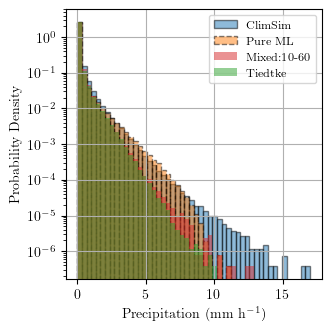

In [21]:
from setup_mpl_tex import setup_mpl_tex

setup_mpl_tex()

fig, ax = plt.subplots(constrained_layout=True, figsize=(6.4/2, 4.8*2/3))

cmap = plt.get_cmap('tab10')
alpha=0.5

print(precip_cs.shape)
print(ds_ml.pr.shape)
print(ds_mix.pr.shape)
print(ds_tiedtke.pr.shape)
precip_cs_np = precip_cs.values.ravel()*unit_conv
precip_ml_np = ds_ml['pr'].values.ravel()*unit_conv
precip_mix_np = ds_mix['pr'].values.ravel()*unit_conv
precip_tiedtke_np = ds_tiedtke['pr'].values.ravel()*unit_conv

maxlim = np.ceil(max([precip_cs_np.max(), precip_tiedtke_np.max(), precip_mix_np.max(), precip_ml_np.max()]))

ax.hist(precip_cs_np, range=(0,maxlim), bins=50, alpha=alpha, color=cmap(0), label='ClimSim', density=True, edgecolor='black', linestyle='-')
ax.hist(precip_ml_np, range=(0,maxlim), bins=50, alpha=alpha, color=cmap(0.1), label='Pure ML', density=True, edgecolor='black', linestyle='--')
ax.hist(precip_mix_np, range=(0,maxlim), bins=50, alpha=alpha, color=cmap(0.3), label=label_mix, density=True)
ax.hist(precip_tiedtke_np, range=(0,maxlim), bins=50, alpha=alpha, color=cmap(0.2), label='Tiedtke', density=True)
ax.set_yscale('log')
ax.legend(fontsize='small')
ax.grid()

ax.set_ylabel('Probability Density')
ax.set_xlabel('Precipitation (mm h$^{-1}$)')

# fig.savefig('Figures/precip_extremes_distribution_24h.pdf')

plt.show()